## Обзор
Данные были разделены на две группы:

- обучающий набор (train.csv)
- тестовый набор (test.csv)

  
Обучающий набор должен использоваться для построения моделей машинного обучения. Для обучающего набора мы предоставляем результат (также известный как «истина на земле») для каждого пассажира. Ваша модель будет основана на «признаках», таких как пол и класс пассажиров. Вы также можете использовать проектирование признаков для создания новых признаков.

Тестовый набор следует использовать для того, чтобы увидеть, насколько хорошо ваша модель работает на невидимых данных. Для тестового набора мы не предоставляем истинные данные для каждого пассажира. Ваша задача — предсказать эти результаты. Для каждого пассажира в тестовом наборе используйте обученную вами модель, чтобы предсказать, выжил ли он после затопления Титаника.

## Импортируем необходимые библиотеки

In [763]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Считываем данные с файла train.cv

Для начала изучим структуру данных

- **PassengerId** — идентификатор пассажира, уникальный для каждого.
- **Survived** — выжил (1) или нет (0).
- **Pclass** — класс обслуживания пассажира (1 = первый класс, 2 = второй класс, 3 = третий класс).
- **Name** — имя пассажира.
- **Sex** — пол (мужчина или женщина).
- **Age** — возраст пассажира.
- **SibSp** — количество братьев, сестёр или супругов на борту.
- **Parch** — количество родителей или детей на борту.
- **Ticket** — номер билета.
- **Fare** — стоимость билета.
- **Cabin** — номер каюты (в некоторых случаях отсутствует).
- **Embarked** — порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton).


In [764]:
df = pd.read_csv('train.csv')

In [765]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: >

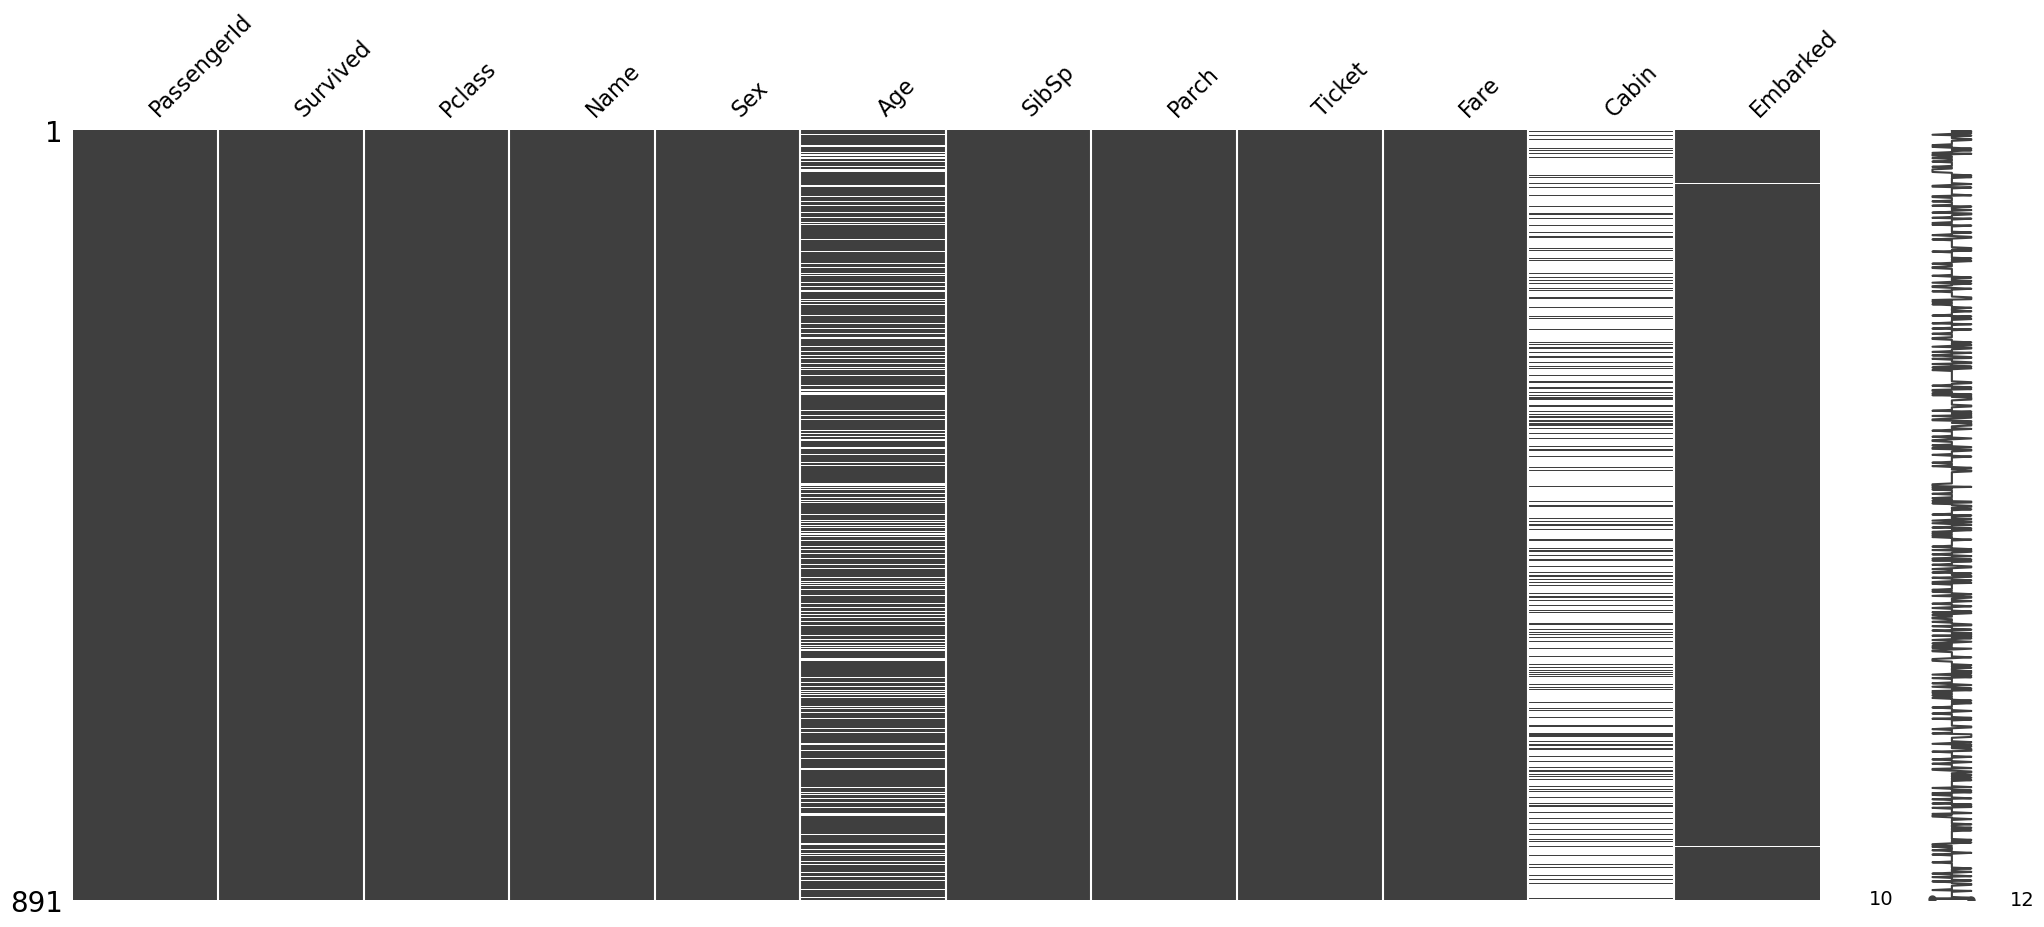

In [766]:
msno.matrix(df)

In [767]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [768]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [769]:
df.shape

(891, 12)

In [770]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Начнем работу с данными

Сделаем из sex бинарный признак
- 0 - male
- 1 - female

И создадим новый столбец из бинерных признаков гендера. Старый удалим.

In [771]:
df['Gender'] = df.apply(lambda x: 0 if x['Sex']=='male' else 1, axis=1)
df.drop(columns='Sex', inplace=True)

In [772]:
df['Embarked'].value_counts().sum()

889

Сделаем из Embarked бинарный признак
- 1 - C
- 2 - Q
- 3 - S
- 0 - Nan

In [773]:
df['Gate'] = df.apply(lambda x: 1 if x['Embarked']=='C' else ( 2 if x['Embarked']=='Q' else ( 3 if x['Embarked']=='S' else 0)), axis=1)
df.drop(columns='Embarked', inplace=True)

In [774]:
df['Gate'].value_counts()

3    644
1    168
2     77
0      2
Name: Gate, dtype: int64

In [775]:
df['Name'][df['Age'].isnull()]

5                              Moran, Mr. James
17                 Williams, Mr. Charles Eugene
19                      Masselmani, Mrs. Fatima
26                      Emir, Mr. Farred Chehab
28                O'Dwyer, Miss. Ellen "Nellie"
                         ...                   
859                            Razi, Mr. Raihed
863           Sage, Miss. Dorothy Edith "Dolly"
868                 van Melkebeke, Mr. Philemon
878                          Laleff, Mr. Kristo
888    Johnston, Miss. Catherine Helen "Carrie"
Name: Name, Length: 177, dtype: object

Извлечем из имен титулы и посчитаем средний возраст для каждого титула. После этого заполним средним значением пустые места колонки Age в соответствии с титулом. Таким образом, мы избавимся от пустот.

In [776]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\\.')  # Извлекаем всё, что перед точкой

print(df[['Name', 'Title']])

                                                  Name Title
0                              Braund, Mr. Owen Harris    Mr
1    Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs
2                               Heikkinen, Miss. Laina  Miss
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs
4                             Allen, Mr. William Henry    Mr
..                                                 ...   ...
886                              Montvila, Rev. Juozas   Rev
887                       Graham, Miss. Margaret Edith  Miss
888           Johnston, Miss. Catherine Helen "Carrie"  Miss
889                              Behr, Mr. Karl Howell    Mr
890                                Dooley, Mr. Patrick    Mr

[891 rows x 2 columns]


In [777]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,3,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,3,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,3,Mrs
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,3,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,3,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,3,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,1,3,Miss
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,0,1,Mr


Посчитаем количество людей, возраст которых входит в диапозон чисел из массива, составленного на основе данных о распределении возраста в колонке Age.

In [778]:
bins = [0, 13, 19, 30, 45, 60, 80]
labels = ['0-13', '13-19', '19-30', '30-45', '45-60', '60-80']

age_group_counts = pd.cut(df['Age'], bins=bins, labels=labels, right=False).value_counts().sort_index()

print(age_group_counts)

0-13      69
13-19     70
19-30    245
30-45    215
45-60     89
60-80     25
Name: Age, dtype: int64


In [779]:
mean_title_gender_age = df.groupby(['Title'])['Age'].mean()

print(mean_title_gender_age)

Title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64


In [780]:
df['Mean_age'] = df['Title'].map(mean_title_age)
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title,Mean_age
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,3,Mr,32.368090
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,Mrs,35.898148
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,3,Miss,21.773973
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,3,Mrs,35.898148
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,3,Mr,32.368090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,3,Rev,43.166667
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,3,Miss,21.773973
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,1,3,Miss,21.773973
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,0,1,Mr,32.368090


In [781]:
df['Age'] = df['Age'].fillna(df['Mean_age'])
df['Age'].isnull().sum()

0

In [782]:
df['Age'] = round(df['Age'], 0)
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title,Mean_age
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,3,Mr,32.368090
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,Mrs,35.898148
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,3,Miss,21.773973
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,3,Mrs,35.898148
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,3,Mr,32.368090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,0,3,Rev,43.166667
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,3,Miss,21.773973
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",22.0,1,2,W./C. 6607,23.4500,NaN,1,3,Miss,21.773973
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,0,1,Mr,32.368090


### Удаляем ненужные колонки

In [783]:
df.drop(columns=['Name', 'Mean_age'], inplace=True)
df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,0,3,Mr
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,1,1,Mrs
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,3,Miss
3,4,1,1,35.0,1,0,113803,53.1000,C123,1,3,Mrs
4,5,0,3,35.0,0,0,373450,8.0500,NaN,0,3,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,211536,13.0000,NaN,0,3,Rev
887,888,1,1,19.0,0,0,112053,30.0000,B42,1,3,Miss
888,889,0,3,22.0,1,2,W./C. 6607,23.4500,NaN,1,3,Miss
889,890,1,1,26.0,0,0,111369,30.0000,C148,0,1,Mr


Убираем колонки Name и Mean_age потому что из имени мы больше не сможем извлечь никакой полезной информации, а колонка среднего возраста уже сыграла свою роль для заполнения пустот.

In [784]:
df.drop(columns=['Ticket'], inplace=True)

Номер билета также не передает никакой важной информации.

In [785]:
df.drop(columns=['Cabin'], inplace=True)

В этом столбце очень много пропусков, из-за которых полезной информации также будет очень мало.

In [786]:
df.drop(columns=['Title'], inplace=True)

Эта колонка также сыграло свою роль в установлении среднего возраста и ольше не нужна.

In [787]:
df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Gate
0,1,0,3,22.0,1,0,7.2500,0,3
1,2,1,1,38.0,1,0,71.2833,1,1
2,3,1,3,26.0,0,0,7.9250,1,3
3,4,1,1,35.0,1,0,53.1000,1,3
4,5,0,3,35.0,0,0,8.0500,0,3
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,3
887,888,1,1,19.0,0,0,30.0000,1,3
888,889,0,3,22.0,1,2,23.4500,1,3
889,890,1,1,26.0,0,0,30.0000,0,1


PassengerId имеет уникальные номера пассажиров, поэтому можем использовать эту колонку в качестве id

In [788]:
df.set_index('PassengerId', inplace=True)

In [789]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Gate
PassengerId,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,3
2,1,1,38.0,1,0,71.2833,1,1
3,1,3,26.0,0,0,7.9250,1,3
4,1,1,35.0,1,0,53.1000,1,3
5,0,3,35.0,0,0,8.0500,0,3
...,...,...,...,...,...,...,...,...
887,0,2,27.0,0,0,13.0000,0,3
888,1,1,19.0,0,0,30.0000,1,3
889,0,3,22.0,1,2,23.4500,1,3


#### Рассмотрим более детально интересные колонки и взаимосвязи данных

In [790]:
df.groupby('Gender').size()

Gender
0    577
1    314
dtype: int64

На борту больше мужчин, чем женщин

In [791]:
df.groupby('Pclass').size()

Pclass
1    216
2    184
3    491
dtype: int64

На борту больше 3 класса

In [792]:

df.groupby('Age').size()

Age
0.0      1
1.0     13
2.0     10
3.0      6
4.0     10
        ..
66.0     1
70.0     3
71.0     2
74.0     1
80.0     1
Length: 71, dtype: int64

In [793]:
df.groupby(['Pclass', 'Gender']).size().unstack()

Gender,0,1
Pclass,,
1,122,94
2,108,76
3,347,144


Во всех классах мужчин больше женщин

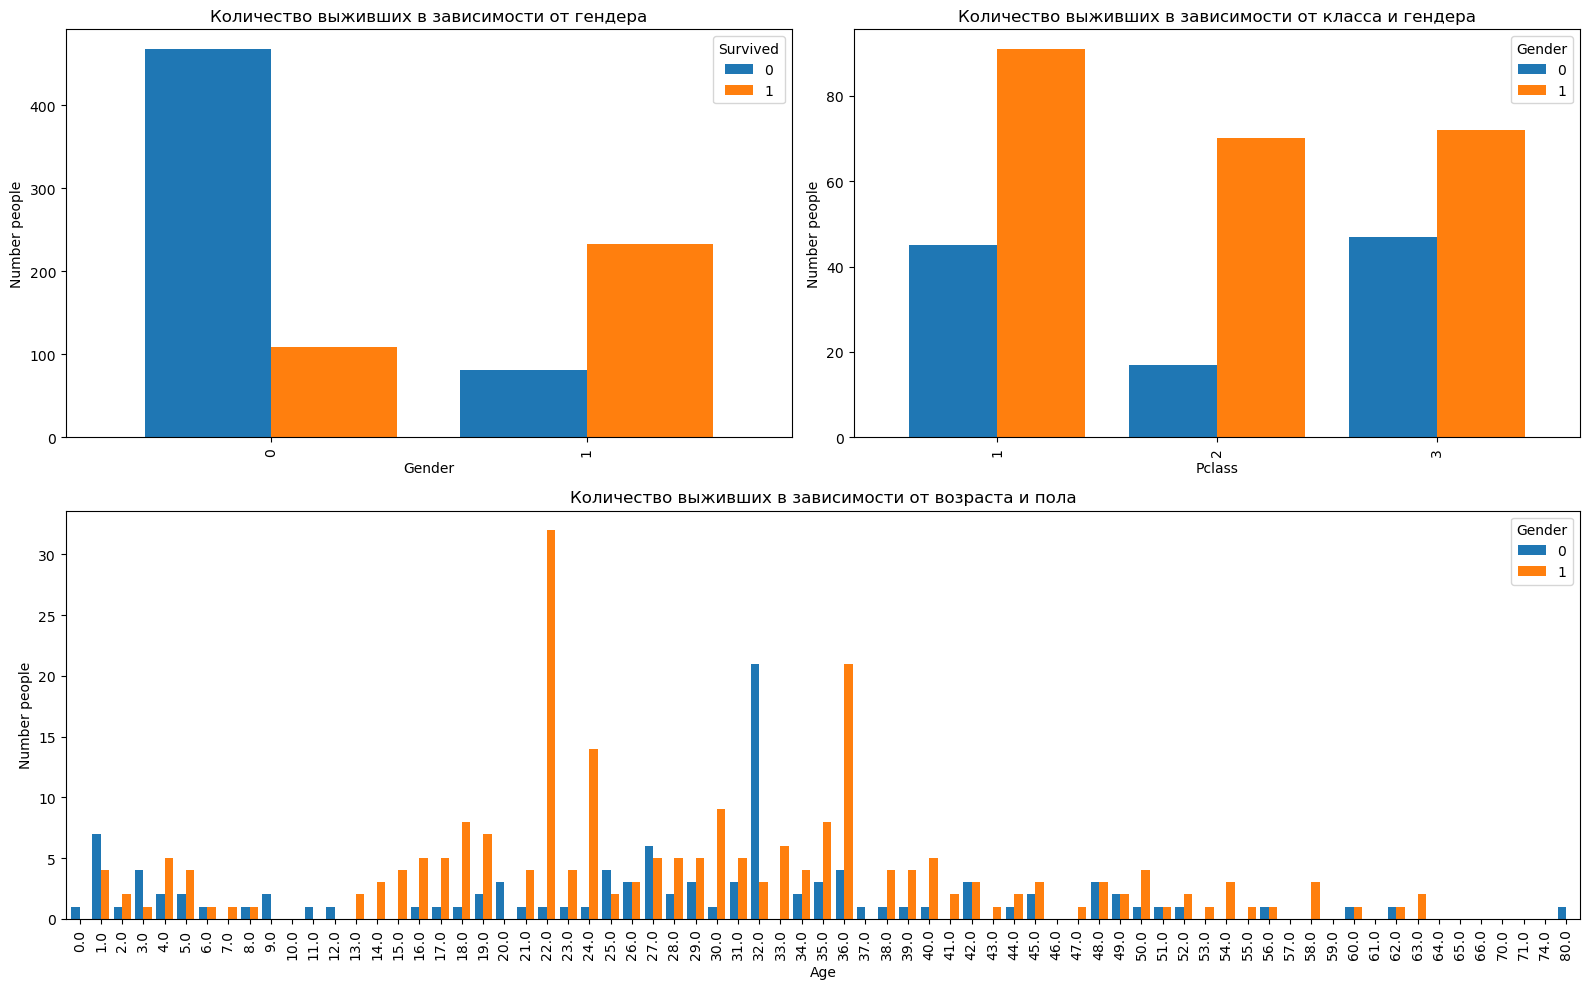

In [794]:
fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(2, 2, 1)
cnt_survival_gender = df.groupby('Gender')['Survived'].value_counts().unstack()
cnt_survival_gender.plot(kind='bar', ax=ax_1, width=0.8)
ax_1.set_title('Количество выживших в зависимости от гендера')
ax_1.set_xlabel('Gender')
ax_1.set_ylabel('Number people')

ax_2 = fig.add_subplot(2, 2, 2)
cnt_survival_pclass = df.groupby(['Pclass', 'Gender'])['Survived'].sum().unstack()
cnt_survival_pclass.plot(kind='bar', ax=ax_2, width=0.8)
ax_2.set_title('Количество выживших в зависимости от класса и гендера')
ax_2.set_xlabel('Pclass')
ax_2.set_ylabel('Number people')

ax_3 = fig.add_subplot(2, 1, 2)
cnt_survival_pclass = df.groupby(['Age', 'Gender'])['Survived'].sum().unstack()
cnt_survival_pclass.plot(kind='bar', ax=ax_3, width=0.8)
ax_3.set_title('Количество выживших в зависимости от возраста и пола')
ax_3.set_xlabel('Age')
ax_3.set_ylabel('Number people')

plt.tight_layout()
plt.show()

- **Из первого графика**: большая доля женщин выжила, несмотря на то что их было меньше, чем мужчин.
- **Из второго графика**: больше женщин спаслось во всех классах, несмотря на то что их было меньше, чем мужчин. Вероятность выжить больше у женщин первого класса.
- **Из третьего графика**: чаще всего выжившими оказывались женщины и дети. 

Сравним количество мужчин и женщин разных возрастов:

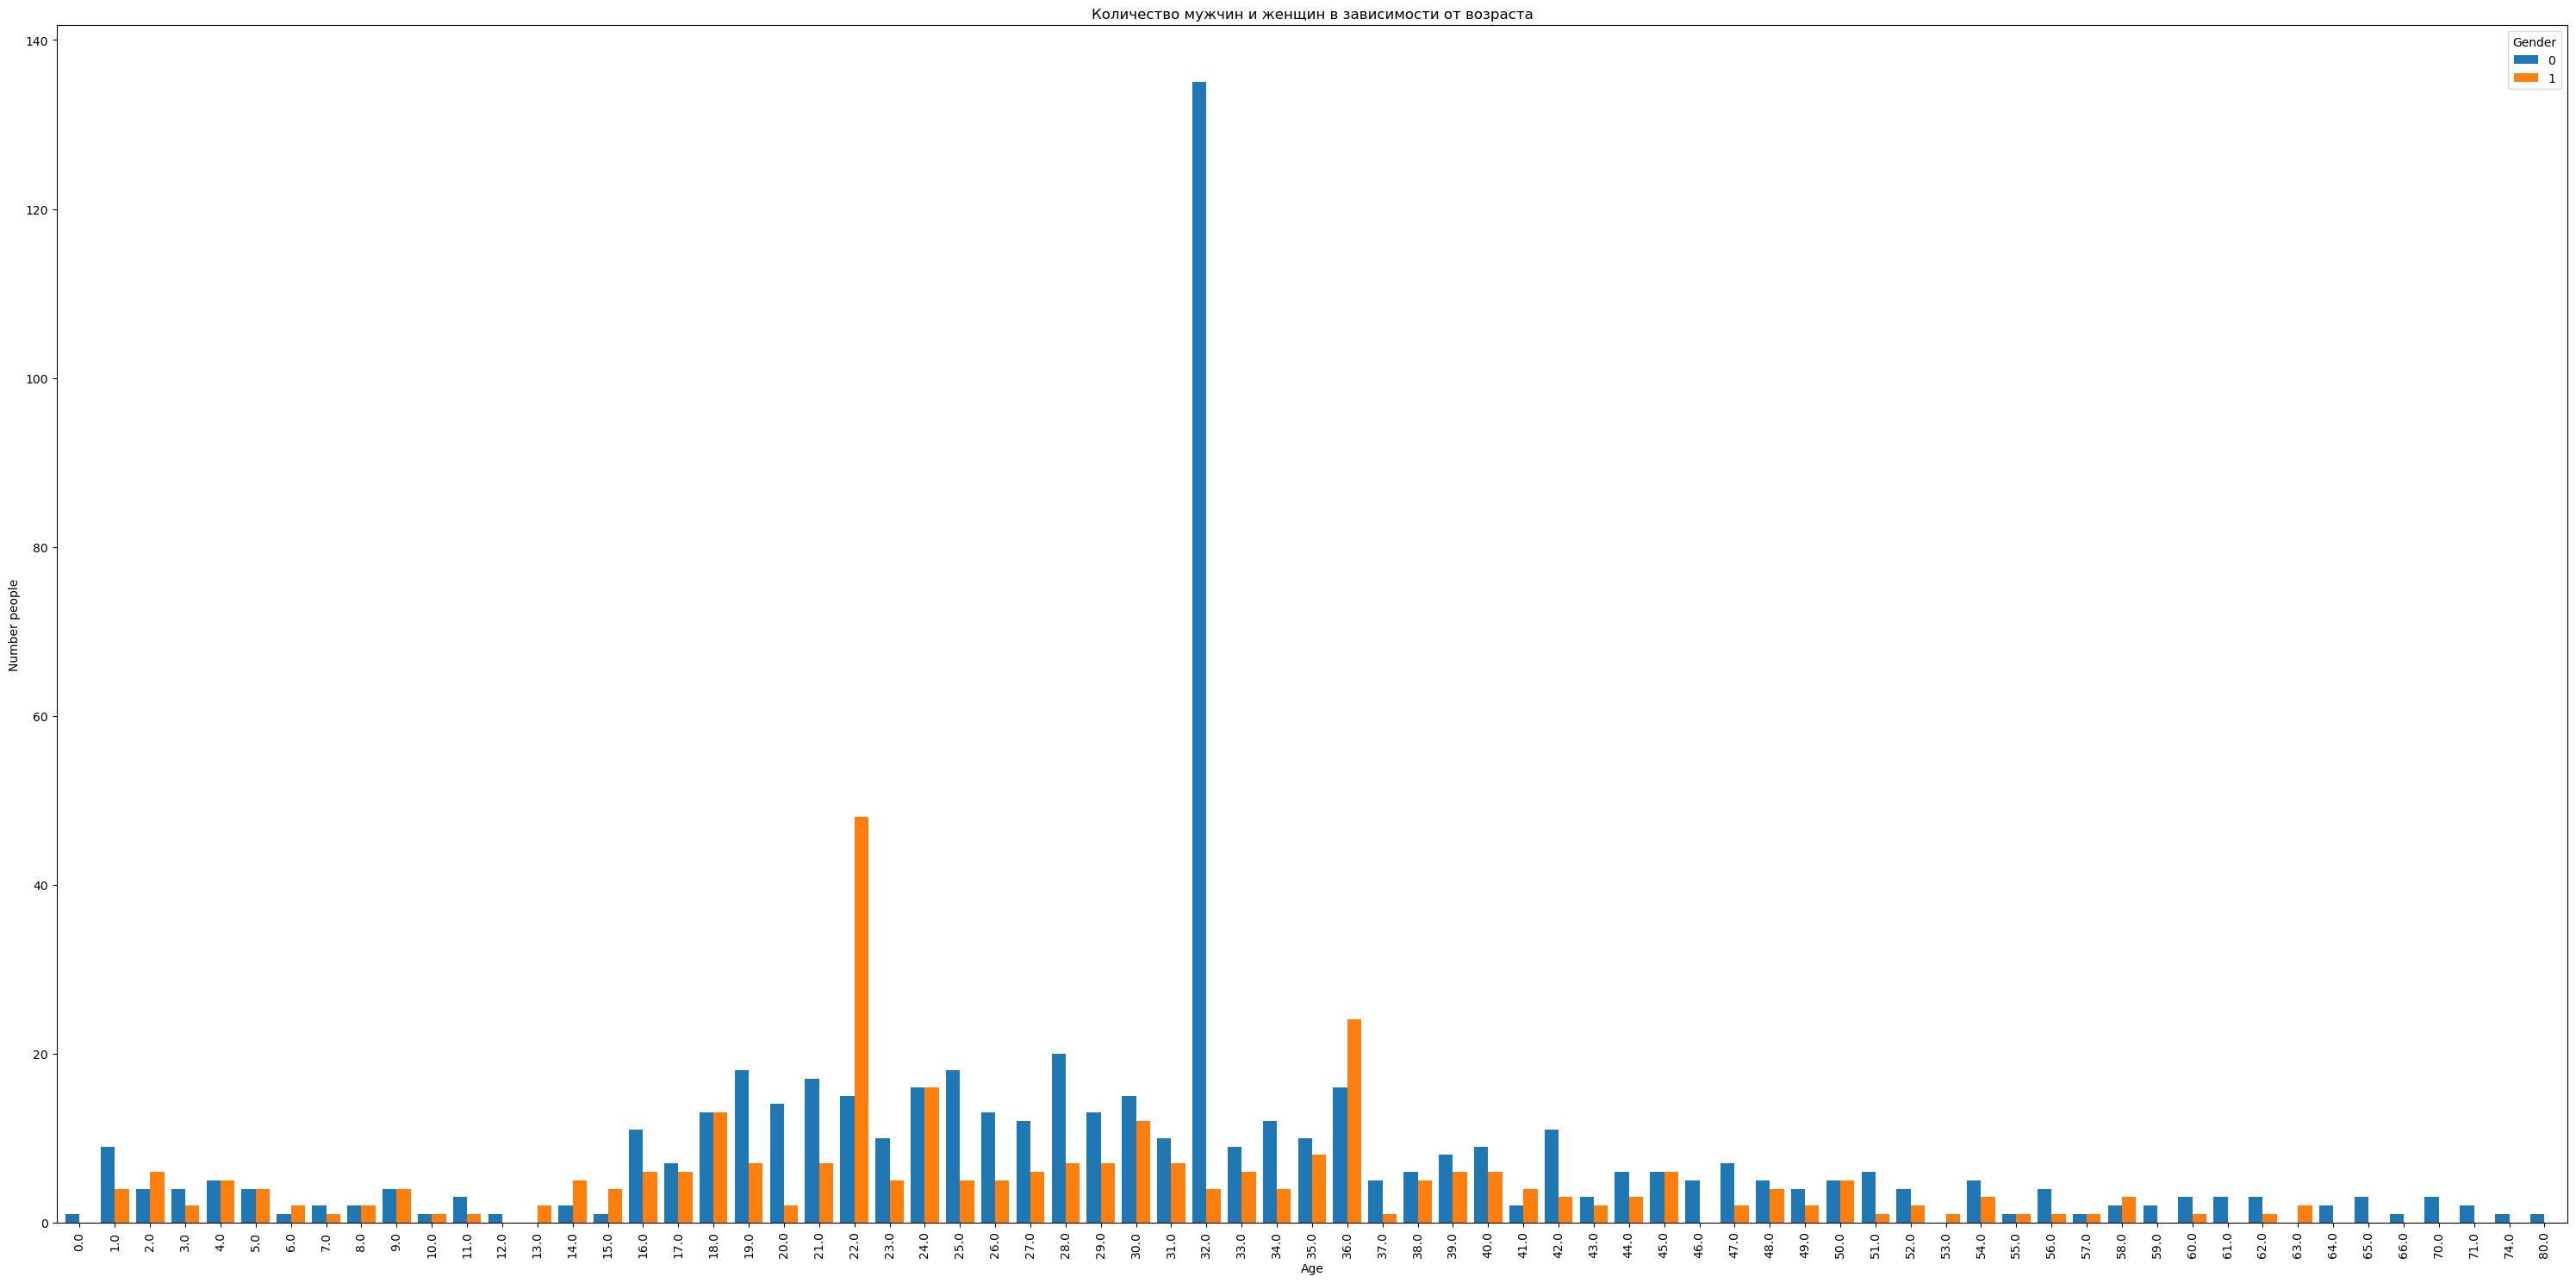

In [795]:
fig = plt.figure()

fig.set_size_inches(30, 15)

cnt_age_gender = df.groupby(['Age', 'Gender']).size().unstack()
cnt_age_gender.plot(kind='bar', width=0.8, ax=fig.gca())
plt.title('Количество мужчин и женщин в зависимости от возраста')
plt.xlabel('Age')
plt.ylabel('Number people')

plt.tight_layout()
plt.show()

Из этого графика видно, что мужчин в каждом возрасте в основном больше женщин. Сравнивая с предыдущим графиком, это означает, что мужчины спасали женщин в первую очередь.

In [796]:
df.groupby('Parch').size()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64

<Figure size 600x400 with 0 Axes>

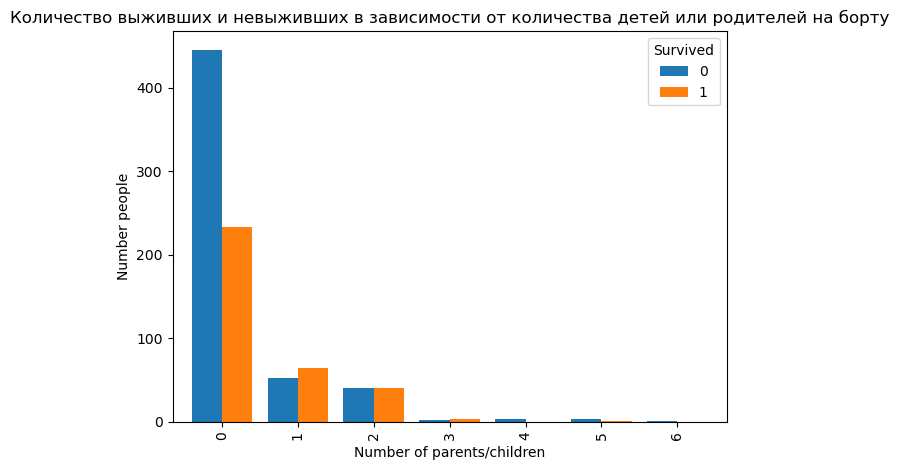

In [797]:
fig = plt.figure()

fig.set_size_inches(6, 4)

cnt_survival = df.groupby(['Parch', 'Survived']).size().unstack(fill_value=0)

# Построение столбчатой диаграммы
cnt_survival.plot(kind='bar', width=0.8)

# Настройка заголовка и меток
plt.title('Количество выживших и невыживших в зависимости от количества детей или родителей на борту')
plt.xlabel('Number of parents/children')
plt.ylabel('Number people')

plt.tight_layout()
plt.show()

Из этого графика видно, что шансы выжить были больше у тех, у кого было меньше родителей/детей и у тех, кто без детей/родителей (таких пассажиров на борту было больше).

<Figure size 600x400 with 0 Axes>

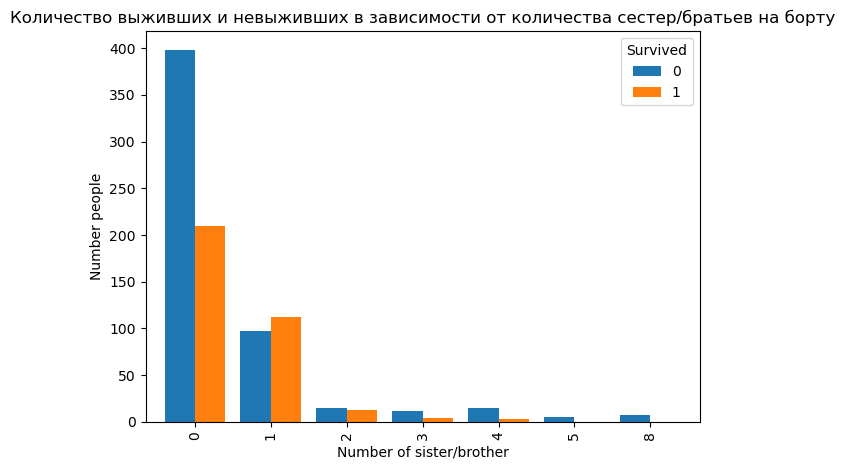

In [798]:
fig = plt.figure()

fig.set_size_inches(6, 4)

cnt_survival = df.groupby(['SibSp', 'Survived']).size().unstack(fill_value=0)

# Построение столбчатой диаграммы
cnt_survival.plot(kind='bar', width=0.8)

# Настройка заголовка и меток
plt.title('Количество выживших и невыживших в зависимости от количества сестер/братьев на борту')
plt.xlabel('Number of sister/brother')
plt.ylabel('Number people')

plt.tight_layout()
plt.show()

Выичслим количество членов семьи каждого пассажира, находившихся на борту, и построим гистограмму зависимости выживших людей с семьями.

In [799]:
df['FamilySize'] = df['SibSp'] + df['Parch']

In [800]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Gate,FamilySize
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,3,1
2,1,1,38.0,1,0,71.2833,1,1,1
3,1,3,26.0,0,0,7.9250,1,3,0
4,1,1,35.0,1,0,53.1000,1,3,1
5,0,3,35.0,0,0,8.0500,0,3,0
...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0,0,13.0000,0,3,0
888,1,1,19.0,0,0,30.0000,1,3,0
889,0,3,22.0,1,2,23.4500,1,3,3


<Figure size 600x400 with 0 Axes>

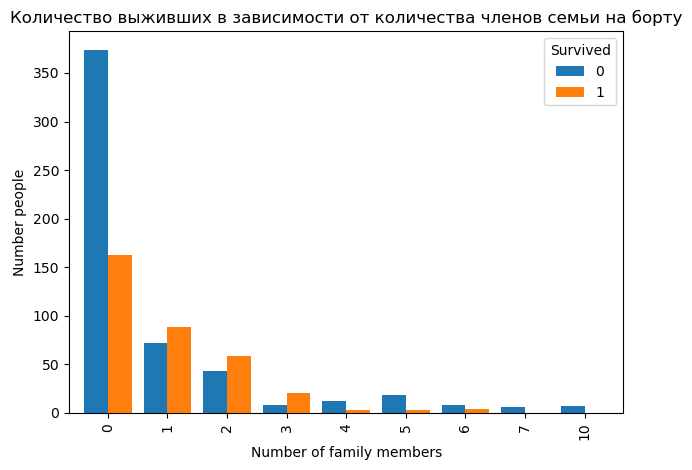

In [801]:
fig = plt.figure()

fig.set_size_inches(6, 4)

cnt_survival_gender = df.groupby(['FamilySize','Survived']).size().unstack(fill_value=0)
cnt_survival_gender.plot(kind='bar', width=0.8)
plt.title('Количество выживших в зависимости от количества членов семьи на борту')
plt.xlabel('Number of family members')
plt.ylabel('Number people')

plt.tight_layout()
plt.show()

Из графиков видим, что больше шансов выжить было у маленьких семей

Посмотрим как повлияло на выживание гендерное различие в семье. 

<Figure size 600x400 with 0 Axes>

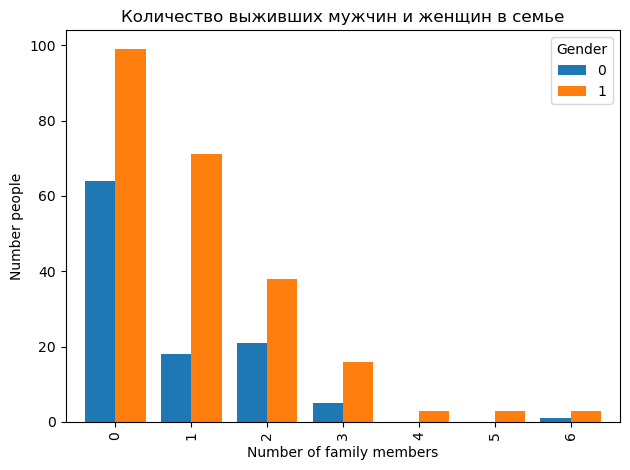

In [802]:
fig = plt.figure()

fig.set_size_inches(6, 4)

cnt_survival_gender = df[df['Survived'] == 1].groupby(['FamilySize', 'Gender']).size().unstack(fill_value=0)
cnt_survival_gender.plot(kind='bar', width=0.8)
plt.title('Количество выживших мужчин и женщин в семье')
plt.xlabel('Number of family members')
plt.ylabel('Number people')

plt.tight_layout()
plt.show()

В каждой семье было больше спасено женщин.

Посмотрим зависимость цены билета и выживаемости.

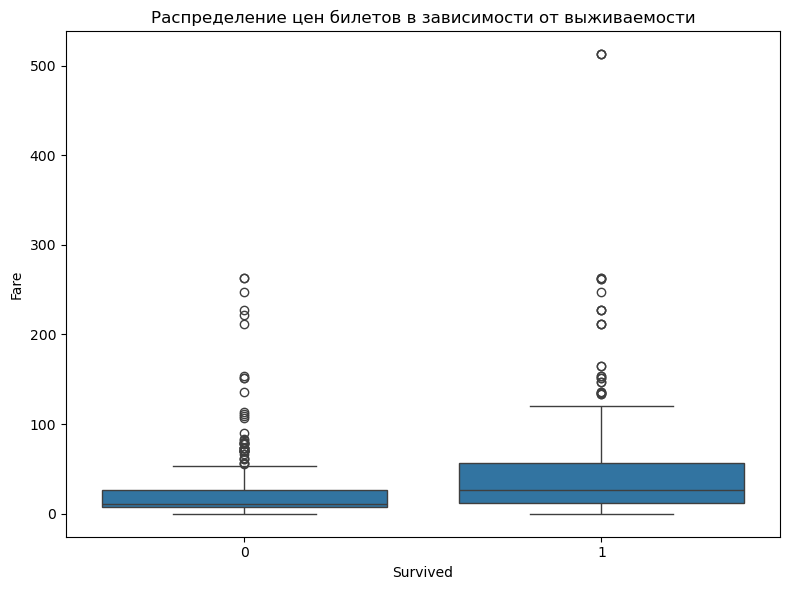

In [803]:
fig = plt.figure()

fig.set_size_inches(8, 6)

sns.boxplot(x='Survived', y='Fare', data=df)

plt.title('Распределение цен билетов в зависимости от выживаемости')
plt.xlabel('Survived')
plt.ylabel('Fare')

plt.tight_layout()
plt.show()

Таким образом, чем дешевле билет, тем больше шансов выжить.

In [804]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Gate,FamilySize
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,3,1
2,1,1,38.0,1,0,71.2833,1,1,1
3,1,3,26.0,0,0,7.9250,1,3,0
4,1,1,35.0,1,0,53.1000,1,3,1
5,0,3,35.0,0,0,8.0500,0,3,0
...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0,0,13.0000,0,3,0
888,1,1,19.0,0,0,30.0000,1,3,0
889,0,3,22.0,1,2,23.4500,1,3,3


<Figure size 600x400 with 0 Axes>

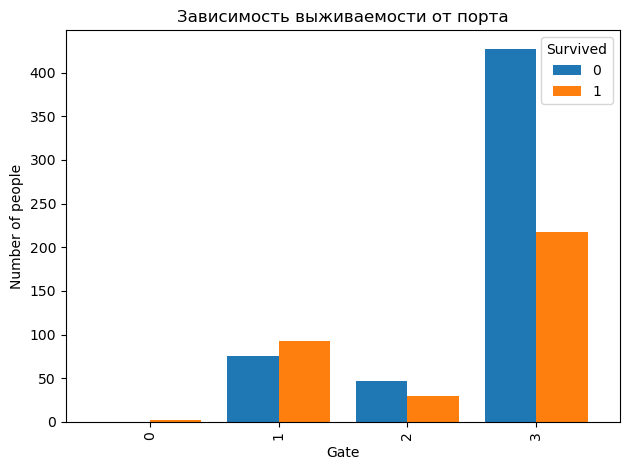

In [805]:
fig = plt.figure()

fig.set_size_inches(6, 4)

cnt_gate_survive = df.groupby(['Gate', 'Survived']).size().unstack(fill_value=0)

cnt_gate_survive.plot(kind='bar', width=0.8)

plt.title('Зависимость выживаемости от порта')
plt.xlabel('Gate')
plt.ylabel('Number of people')

plt.tight_layout()
plt.show()

In [806]:
new_df = df.drop(columns=['SibSp', 'Parch'])

In [807]:
new_df

,Survived,Pclass,Age,Fare,Gender,Gate,FamilySize
PassengerId,,,,,,,
1,0,3,22.0,7.2500,0,3,1
2,1,1,38.0,71.2833,1,1,1
3,1,3,26.0,7.9250,1,3,0
4,1,1,35.0,53.1000,1,3,1
5,0,3,35.0,8.0500,0,3,0
...,...,...,...,...,...,...,...
887,0,2,27.0,13.0000,0,3,0
888,1,1,19.0,30.0000,1,3,0
889,0,3,22.0,23.4500,1,3,3


In [808]:
corr_matrix_new = new_df.corr()
print(corr_matrix_new)

            Survived    Pclass       Age      Fare    Gender      Gate  \
Survived    1.000000 -0.338481 -0.086406  0.257307  0.543351 -0.176509   
Pclass     -0.338481  1.000000 -0.345070 -0.549500 -0.131900  0.173511   
Age        -0.086406 -0.345070  1.000000  0.092301 -0.113672 -0.036315   
Fare        0.257307 -0.549500  0.092301  1.000000  0.182333 -0.230365   
Gender      0.543351 -0.131900 -0.113672  0.182333  1.000000 -0.118492   
Gate       -0.176509  0.173511 -0.036315 -0.230365 -0.118492  1.000000   
FamilySize  0.016639  0.065997 -0.279660  0.217138  0.200988  0.070511   

            FamilySize  
Survived      0.016639  
Pclass        0.065997  
Age          -0.279660  
Fare          0.217138  
Gender        0.200988  
Gate          0.070511  
FamilySize    1.000000  


In [811]:
model = LogisticRegression()

x = new_df.drop(columns='Survived')
y = new_df['Survived']

model.fit(x, y)

prediction = model.predict(x)

accuracy = accuracy_score(y, prediction)
print(accuracy)

0.8058361391694725


In [837]:
x

,Pclass,Age,Fare,Gender,Gate,FamilySize
PassengerId,,,,,,
1,3,22.0,7.2500,0,3,1
2,1,38.0,71.2833,1,1,1
3,3,26.0,7.9250,1,3,0
4,1,35.0,53.1000,1,3,1
5,3,35.0,8.0500,0,3,0
...,...,...,...,...,...,...
887,2,27.0,13.0000,0,3,0
888,1,19.0,30.0000,1,3,0
889,3,22.0,23.4500,1,3,3


In [840]:
x.dtypes

Pclass          int64
Age           float64
Fare          float64
Gender          int64
Gate            int64
FamilySize      int64
dtype: object

In [838]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [812]:
new_df.dtypes

Survived        int64
Pclass          int64
Age           float64
Fare          float64
Gender          int64
Gate            int64
FamilySize      int64
dtype: object

## Протестируем модель на тестовой выборке

In [852]:
test_df = pd.read_csv('test.csv')

In [814]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [815]:
test_df['Gender'] = test_df.apply(lambda x: 0 if x['Sex']=='male' else 1, axis=1)
test_df.drop(columns='Sex', inplace=True)

In [816]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,0


In [817]:
test_df['Gate'] = test_df.apply(lambda x: 1 if x['Embarked']=='C' else ( 2 if x['Embarked']=='Q' else ( 3 if x['Embarked']=='S' else 0)), axis=1)
test_df.drop(columns='Embarked', inplace=True)

In [818]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,3
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,2
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,3
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,3
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,3
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,3


In [819]:
test_df['Title'] = test_df['Name'].str.extract('([A-Za-z]+)\\.')

In [820]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,2,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,3,Mrs
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,2,Mr
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,3,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,3,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,3,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,1,Dona
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,3,Mr
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,3,Mr


In [821]:
mean_title_gender_age = test_df.groupby(['Title'])['Age'].mean()
print(mean_title_gender_age)

Title
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Ms              NaN
Rev       35.500000
Name: Age, dtype: float64


In [822]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,2,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,3,Mrs
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,2,Mr
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,3,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,3,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,3,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,1,Dona
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,3,Mr
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,3,Mr


In [823]:
test_df['Mean_age'] = test_df['Title'].map(mean_title_gender_age)
test_df['Mean_age'].isnull().sum()

1

In [824]:
mean_age_women = test_df[test_df['Gender'] == 1]['Age'].mean()

test_df.loc[test_df['Title'] == 'Ms', 'Age'] = test_df.loc[test_df['Title'] == 'Ms', 'Age'].fillna(mean_age_women)

In [825]:
test_df[test_df['Title'] == 'Ms']

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title,Mean_age
88,980,3,"O'Donoghue, Ms. Bridget",30.272362,0,0,364856,7.75,NaN,1,2,Ms,NaN


In [826]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Age             85
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Gender           0
Gate             0
Title            0
Mean_age         1
dtype: int64

In [827]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Gender,Gate,Title,Mean_age
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,2,Mr,32.000000
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,3,Mrs,38.903226
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,2,Mr,32.000000
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,3,Mr,32.000000
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,3,Mrs,38.903226
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,3,Mr,32.000000
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,1,Dona,39.000000
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,3,Mr,32.000000
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,3,Mr,32.000000


In [828]:
test_df['Age'] = test_df['Age'].fillna(test_df['Mean_age'])
df['Age'].isnull().sum()

0

In [829]:
test_df.drop(columns=['Name', 'Mean_age'], inplace=True)

In [830]:
test_df.drop(columns=['Ticket', 'Cabin'], inplace=True)

In [831]:
test_df.drop(columns=['Title'], inplace=True)

In [832]:
test_df.set_index('PassengerId', inplace=True)

In [833]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

In [834]:
new_df_2 = test_df.drop(columns=['SibSp', 'Parch'])

In [835]:
new_df_2['Age'] = round(new_df_2['Age'], 0)

In [836]:
new_df_2

,Pclass,Age,Fare,Gender,Gate,FamilySize
PassengerId,,,,,,
892,3,34.0,7.8292,0,2,0
893,3,47.0,7.0000,1,3,1
894,2,62.0,9.6875,0,2,0
895,3,27.0,8.6625,0,3,0
896,3,22.0,12.2875,1,3,2
...,...,...,...,...,...,...
1305,3,32.0,8.0500,0,3,0
1306,1,39.0,108.9000,1,1,0
1307,3,38.0,7.2500,0,3,0


In [839]:
new_df_2.dtypes

Pclass          int64
Age           float64
Fare          float64
Gender          int64
Gate            int64
FamilySize      int64
dtype: object

In [842]:
new_df_2.isnull().sum()

Pclass        0
Age           0
Fare          1
Gender        0
Gate          0
FamilySize    0
dtype: int64

In [846]:
median_fare_by_class = new_df_2.groupby('Pclass')['Fare'].median()
new_df_2['Fare'].fillna(new_df_2['Pclass'].map(median_fare_by_class), inplace=True)

In [847]:
new_df_2.isnull().sum()

Pclass        0
Age           0
Fare          0
Gender        0
Gate          0
FamilySize    0
dtype: int64

In [848]:
x_test = new_df_2
prediction = model.predict(x_test)

In [849]:
print(prediction)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [853]:
output = pd.DataFrame({'PassengerId':test_df.PassengerId, 'Survived':prediction})
output.to_csv('my_submission.csv', index=False)